# SETI Energy Detection 

#### Original Code By Yuhong | [Original Code](https://github.com/FX196/SETI-Energy-Detection) 
#### Notebook By Peter Ma | [Contact](https://PETERMA.CA) 

When conducting an ETI search we often look for certain hallmarks of an engineered signal. Of the many possible ETI signal characteristics, an energized narrowband signal is an important indicator. Loosely speaking, this is based on the assumption that if an ETI had the intention to be found, they'd likely produce a 'loud signal' (high intensity and a high SNR) in order to 'get our attention'. 

In this notebook we will show a statistical method in detecting a highly energized signal.


# The Breakthrough Listen Data and How To Get It 

Breakthrough Listen data is typically stored in 3 types of radio spectrogram resolutions used for different types of searches. 


1. `Fine Resolution` - Sacrifices time resolution for high-frequency resolution

2. `Time Resolution` - Sacrifices high-frequency resolution for high time resolution

3. `Mid Resolution` - inbetween case with an 'inbetween' time, and frequency resolution.



For a formal documentation on the data products [check out the paper](https://arxiv.org/pdf/1906.07391.pdf). To get the open sourced data, check out the archive [data](https://arxiv.org/pdf/1906.07391.pdf)

**IMPORTANT**: Ideally we want to work with `Fine Resolution` data as we are searching for narrowband signals that would require a high frequency resolution that may be within a few `KHz` in width. Furthermore, since we care about the energy of the signal, more so then the actual modulation of the signal, we can afford to sacrifice the time resolution of the data. *However we will be working with a* `mid resolution` *product as an example. This makes this notebook run fast enough for most computers and COLAB.*

# Blimpy I/O Library 

In order to interface with this data we have a python library `BLIMPY` where it makes it easier to work with +10GB of data.

**NOTE**: We will be working with very large datasets that may be resource-intensive. Advise you to port this notebook to a COLAB enviroment.




In [11]:
!pip install blimpy
# Note this full resolution file is over 14GB in size. Moving this to colab it downloads in <5 minutes
!wget 	http://blpd7.ssl.berkeley.edu/dl2/GBT_57532_09539_HIP56445_fine.h5
# Time resolution file
# !wget 	http://blpd13.ssl.berkeley.edu/dl/GBT_57532_09539_HIP56445_time.h5
# This is the mid resolution notebook.
# !wget http://blpd7.ssl.berkeley.edu/dl2/GBT_57532_09539_HIP56445_mid.h5

--2020-06-06 23:21:15--  http://blpd7.ssl.berkeley.edu/dl2/GBT_57532_09539_HIP56445_fine.h5
Resolving blpd7.ssl.berkeley.edu (blpd7.ssl.berkeley.edu)... 208.68.240.73
Connecting to blpd7.ssl.berkeley.edu (blpd7.ssl.berkeley.edu)|208.68.240.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15271502711 (14G) [application/octet-stream]
Saving to: ‘GBT_57532_09539_HIP56445_fine.h5’

GBT_57532_09539_HIP 100%[===================>]  14.22G  38.1MB/s    in 6m 24s  

2020-06-06 23:27:39 (37.9 MB/s) - ‘GBT_57532_09539_HIP56445_fine.h5’ saved [15271502711/15271502711]



In [0]:
import numpy as np
from scipy import stats, interpolate
from blimpy import Waterfall
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm
import dask.array as da
import h5py as h5
import os
import pandas as pd
import pylab as plt
from copy import deepcopy

# Loading Data

Here we load the data using `BLIMPY` object. Note, we are using the `mid` resolution data for some target `HIP56445`

`obs.info()` gives us important header information . The header information gives vital information about the observational setup of the telescope. For example, the coarse channel width or the observation time and duration, etc.

We also want to compute the coarse channel width. Which is shown in `channel_len`

blimpy.io.base_reader INFO     Skipping loading data ...

--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                1926.26953125 MHz
            foff :       -2.835503418452676e-06 MHz
      machine_id :                               20
           nbits :                               32
          nchans :                        318230528
            nifs :                                1
     source_name :                         HIP56445
         src_dej :                      3:03:34.006
         src_raj :                     11:34:21.699
    telescope_id :                                6
           tsamp :                     17.986224128
   tstart (ISOT) :          2016-05-24T02:38:59.000
    tstart (MJD) :                57532.11040509259
        za_start :                              0.0

Num ints in file :                    

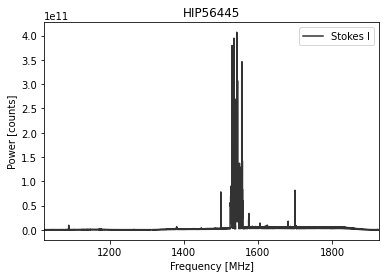

In [18]:
%matplotlib inline
obs = Waterfall("/content/GBT_57532_09539_HIP56445_fine.h5", load_data=False)
obs.info()
# We are taking a small selection of the spectrum between 
# 1023.92mHz - 1028.92mHz. 
# obs = Waterfall("/content/GBT_57532_09539_HIP56445_fine.h5",  f_stop=1023.92578125+20, max_load=5)
obs = Waterfall("/content/GBT_57532_09539_HIP56445_mid.h5", t_stop=80000, max_load=5)
data = obs.data
# Channel width of 1033216 np index. 
channel_len  = np.int(np.round(187.5/64/abs(obs.header['foff'])))
print(data.shape)
print("Channel Width: "+str(channel_len))
obs.plot_spectrum()

# Bandpass Removal 
### Preprocessing
The goal of this process is to clean the data of its artifacts created by combining multiple bands. Our data is created by taking sliding windows of the raw voltage data and computing an FFT of that sliding window. With these FFTs (each containing frequency information about a timestamp) for each coarse channel, we use a bandpass filter to cut off frequencies that don’t belong to that coarse channel’s frequency range. But we can’t make a perfect cut, and that’s why there's a falling off at the edges.

They’re called band-pass because they only allow signals in a particular frequency range, called a band, to pass-through. When we assemble the products we see these dips in the spectrogram. In other words - they aren't real signals.

To remove the bandpass features, we use spline lines to fit each channel to get a model of the bandpass of that channel. By using splines, we can fit the bandpass without fitting the more significant signals.

If you want more details on this check out [Yuhong's work](https://github.com/FX196/SETI-Energy-Detection) for a detailed explanation. 


In [0]:
%matplotlib inline
# Set up arrays to hold the data manipulations 
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
spl_order = 2
print("Fitting Spline")
data_adjust = np.zeros(data.shape)
average_power = data.mean(axis=0)
coarse_channel_width = channel_len
for i in tqdm(range(0, data.shape[2],coarse_channel_width)):
  # For each coarse channel we preform a spline fit and subtract the fit from the data.
    average_channel = average_power[0,i:i+coarse_channel_width]
    x = np.arange(0,coarse_channel_width,1)
    knots = np.arange(0, coarse_channel_width, coarse_channel_width//spl_order+1)
    tck = interpolate.splrep(x, average_channel, s=knots[1:])
    xnew = np.arange(0, coarse_channel_width,1)
    ynew = interpolate.splev(xnew, tck, der=0)
    data_adjust[:,0,i:i+coarse_channel_width]  = data[:,0,i:i+coarse_channel_width] - ynew

# Plot the newly adjusted average power across time per frequency. 
plt.figure()
plt.plot( data_adjust.mean(axis=0)[0,:])
plt.title('Spline Fit - adjusted')
plt.xlabel("Fchans")
plt.ylabel("Power")

# Compute Statistical Likelihood of Signal

When given an observation we want to compute the statistical likelihood of the signal occuring due to noise given its intensity. Since the noise picked up during observation is said to be Gaussian, all we need to do is compute the normal distribution of a window of the spectrogram and then compute the Z-scores of the signals. The greater the signal is away from the central mean the more statistically "anomalous" it is in terms of its energy.

<p align="center" height="200px"> 
    <img src="https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-statistics-toolbox/GUID-CBF63B74-D1B2-44FC-A316-7AC2B1C1D464-web.png">
</p>


Given the Z-score calculations we also want to compute the p-values of each window slice. The p-value threshold `p < 1e-25` is used to help reject a null-hypothesis where a statistical anomaly would likely appear given a non-anomalous situation. If it is unlikely that during a non-anomalous situation an anomalous event could occur, then we accept the alternative hypothesis. The alternative being that this signal isn't random noise. 

In other words we are asking, how likely is this 'weird' event to occur assuming there it came from noise. P-values help use judge the statistical significance of a given event. 

In [0]:
# Computes normal distribution of the signal.
# Noise is assumed to be Gaussian  
def norm_test(arr):
  # Uses scipy lib to compute the P-values and Z scores
    return stats.normaltest(arr.flatten())
def top(arr, top = 10):
  newarr=deepcopy(arr)
  candidate = []
  for i in range(top):
    # We add 1 as the 0th index = period of 1 not 0
    index = np.argmax(newarr)
    candidate.append(index)
    newarr[index]=0
  return candidate

In [0]:
res = []
slice_length = 32
# slice_length = int(1033216/2**4)
num_chan = int(data.shape[2]/channel_len)
data_temp=data_adjust[:,0,:]
for chan in tqdm(range(num_chan)):
  res.append([])
  window = data_temp[:, channel_len*(chan):channel_len*(chan+1)]
  for i in range(0, channel_len-slice_length, 1):
    test_data = window[:, i:i+slice_length]
    s, p = norm_test(test_data)
    # We filter out p_values by a threshold to reject or accept the
    # null hypothesis 
    if p < 1e-25:
      res[chan].append((i, s, p))
    else:
      res[chan].append((i, 0, p))
chan_hits = res

In [0]:
result = np.zeros(((len(res))*(len(res[1])), 3))
for i in range(len(res)):
  for k in range(len(res[0])):
    result[i*(channel_len- slice_length)+k,0]=i*(channel_len- slice_length)+k
    result[i*(channel_len- slice_length)+k,1]=res[i][k][1]
    result[i*(channel_len- slice_length)+k,2]=res[i][k][2]

# Concluding Result

After filtering out statistically insignificant events. We then look for the greatest Z scores given by the `s values` from our calculations. We picked the top 3 to show to illustrate the types of signals it has found. 

Fchan (MHz): 1294.6958541870117 S_VAL: 29869.50585032777
Fchan (MHz): 1294.8102951049805 S_VAL: 28575.65756243504


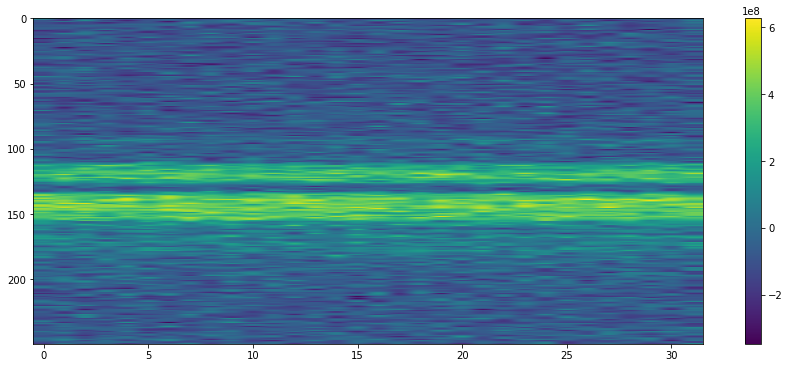

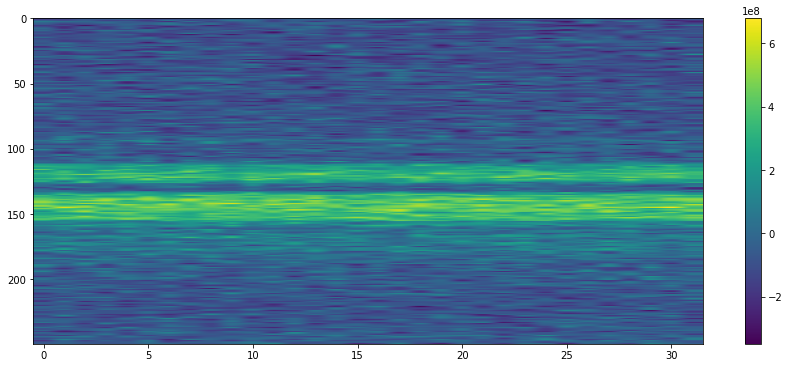

In [31]:
# slice just the z_scores of the signals
s_val = result[:,1]
candidates = []
candidates = top(s_val, top=2)

for i in range(len(candidates)):
  max_index = candidates[i]
  print("Fchan (MHz): "+str(max_index*(-obs.header['foff'])+(obs.header['fch1']+obs.header['foff']*data.shape[2]))+" S_VAL: "+str(result[max_index,1]))
  f_low = max_index - int(slice_length/2)
  f_high = max_index + int(slice_length/2)
  fig = plt.figure(figsize=(15, 6))
  plt.imshow(data_adjust[:250,0,f_low:f_high], aspect='auto')
  plt.colorbar()